In [175]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from infodenguepredict.data.infodengue import get_cluster_data, get_alerta_table
from infodenguepredict.predict_settings import PREDICTORS, DATA_TYPES, STATE
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [188]:
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def class_report(y_true, y_predict, title='Avaliação', target_names=['Classe 0', 'Classe 1',]):
    print('Classification Report for feature: {}'.format(title))
    print(classification_report(y_true, y_predict, target_names=target_names))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_predict)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_predict)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_predict)))
    print('f1 Score: {}'.format(f1_score(y_true, y_predict)))

In [4]:
def build_model(**kwargs):
    model = RandomForestRegressor(max_depth=None, random_state=0, n_jobs=-1,
                                  n_estimators=1000,
                                  warm_start=True,oob_score=True)
    # model = ExtraTreesRegressor(max_depth=None, random_state=0, n_jobs=-1,
    #                               n_estimators=1000,
    #                               warm_start=True)

    return model

In [5]:
def build_lagged_features(dt, lag=2, dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    :param dt: Dataframe containing features
    :param lag: maximum lags to compute
    :param dropna: if true the initial rows containing NANs due to lagging will be dropped
    :return: Dataframe
    '''
    if type(dt) is pd.DataFrame:
        new_dict = {}
        for col_name in dt:
            new_dict[col_name] = dt[col_name]
            # create lagged Series
            for l in range(1, lag + 1):
                new_dict['%s_lag%d' % (col_name, l)] = dt[col_name].shift(l)
        res = pd.DataFrame(new_dict, index=dt.index)

    elif type(dt) is pd.Series:
        the_range = range(lag + 1)
        res = pd.concat([dt.shift(-i) for i in the_range], axis=1)
        res.columns = ['lag_%d' % i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [6]:
def rolling_forecasts(data, target, window=12, horizon=1):
    """
    Fits the rolling forecast model
    :param data: feature Dataframe
    :param window: lookback window
    :param horizon: forecast horizon
    :param target: variable to be forecasted
    :return:
    """
    model = build_model()
    model.fit(data.values, target)
    # for i in range(0, ldf.shape[0] - window):
    #     model.fit(ldf.values[i:i + window, :], ldf['target'].values[i:i + window])

    return model

In [168]:
def plot_prediction(Xdata, ydata, model, title, shift=None, horizon=None):
    plt.figure()
    preds = model.predict(Xdata.values)
    preds = preds[-(len(ydata)+d):-d]
    plt.plot(ydata, alpha=0.3, label='Data')

    preds_series = pd.Series(data=preds, index=list(ydata.index))

    plt.plot(preds_series, ':', label='RandomForest')

    plt.legend(loc=0)
    plt.title(title)
    plt.savefig('RandomForest{}_{}.png'.format(city, title))

    return preds_series

In [8]:
lookback = 12
horizon = 4  # weeks
city = 3304557
target = 'casos_{}'.format(city)
with open('infodenguepredict/analysis/clusters_{}.pkl'.format(STATE), 'rb') as fp:
    clusters = pickle.load(fp)
data, group = get_cluster_data(city, clusters=clusters, data_types=DATA_TYPES, cols=PREDICTORS)


/home/elisa/.local/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


In [110]:
data_lag = build_lagged_features(data, lookback)
data_lag.dropna()
targets = {}
for d in range(1, horizon + 1):
    targets[d] = data_lag[target].shift(-d)[:-horizon]

X_train, X_test, y_train, y_test = train_test_split(data_lag, data_lag[target],
                                                    train_size=0.7, test_size=0.3, shuffle=False)
X_test = X_test.iloc[:-horizon]

In [111]:
d=4
tgt = targets[d][:len(X_train)]
tgtt = targets[d][len(X_train):]
model = rolling_forecasts(X_train, target=tgt, horizon=horizon)

In [165]:
# pd.DataFrame({'input_data':data_lag.index, 'output':preds, 'output_data':data_lag.index.shift(4),
#              'input_val':preds_series.shift(4)})

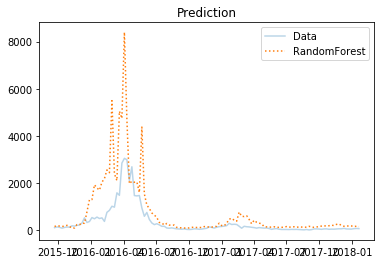

In [169]:
preds = plot_prediction(data_lag, y_test, model, title='Prediction', shift=d, horizon=horizon)

In [170]:
preds

2015-09-20     161.263
2015-09-27     199.370
2015-10-04     179.178
2015-10-11     163.045
2015-10-18     176.392
2015-10-25     211.000
2015-11-01     163.179
2015-11-08      92.650
2015-11-15      99.004
2015-11-22     242.354
2015-11-29     238.290
2015-12-06     307.429
2015-12-13     296.872
2015-12-20     788.668
2015-12-27    1300.487
2016-01-03    1304.440
2016-01-10    1929.915
2016-01-17    1795.139
2016-01-24    1701.417
2016-01-31    2040.863
2016-02-07    2191.387
2016-02-14    2558.480
2016-02-21    2444.119
2016-02-28    5494.686
2016-03-06    2396.109
2016-03-13    2107.012
2016-03-20    5046.808
2016-03-27    4744.335
2016-04-03    8393.512
2016-04-10    4705.236
                ...   
2017-07-02     158.071
2017-07-09     126.663
2017-07-16     153.838
2017-07-23     149.085
2017-07-30     125.646
2017-08-06     145.761
2017-08-13     137.525
2017-08-20     136.956
2017-08-27     129.482
2017-09-03     167.640
2017-09-10     154.133
2017-09-17     122.146
2017-09-24 

In [183]:
def create_Q(city, state):
    data = get_alerta_table(city, 'RJ')
    data = data[['casos', 'SE']].reset_index(drop=True)
    
    data.SE = [str(i)[-2:] for i in data.SE]
    Q = data.groupby('SE').median()
    Q['std'] = data.groupby('SE').std()['casos']
    return Q, data.SE.values

def build_y_test(row,k):
    if abs(row['real'] - row['mediana']) < k*row['std']:
        return 1
    else:
        return 0
    
def build_y_pred(row, k):
    if abs(row['preds'] - row['mediana']) < k*row['std']:
        return 1
    else:
        return 0
    
def matrix(city, preds, real, Q, SE, k):
    df = pd.DataFrame({'preds':preds, 'SE':SE[-len(preds):], 'real':real})
    to_merge = pd.DataFrame({'mediana':Q['casos'.format(city)],
                            'std':Q['std']}).reset_index()    
    df = df.merge(to_merge,how='left', on='SE')  
    
    df['y_test'] = df.apply(build_y_test, axis=1, args=(k,))
    df['y_pred'] = df.apply(build_y_pred, axis=1, args=(k,))
    cnf_matrix = confusion_matrix(df.y_test, df.y_pred)
    class_report(df.y_test, df.y_pred)
    plot_confusion_matrix(cnf_matrix, classes=('not_expected','expected'))
    

In [184]:
Q, SE = create_Q(city, 'RJ')

Classification Report for feature: Avaliação
             precision    recall  f1-score   support

   Classe 0       0.31      0.61      0.41        33
   Classe 1       0.78      0.51      0.62        90

avg / total       0.65      0.54      0.56       123

ROC Score: 0.5585858585858586
Accuracy Score: 0.5365853658536586
Average Precision Score: 0.7562169858986725
f1 Score: 0.6174496644295301
Confusion matrix, without normalization
[[20 13]
 [44 46]]


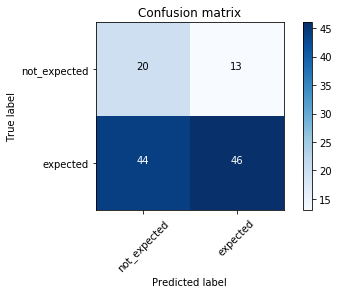

In [207]:
matrix(city, preds,y_data, Q, SE, 0.4)

In [72]:
#errado
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1,-1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [413]:
err_down,err_up = pred_ints(model, X_test.values)

In [414]:
truth = y_test[d:-(horizon-d)]
correct = 0.
for i, val in enumerate(truth):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print(correct/len(truth))

0.9895833333333334


<Container object of 3 artists>

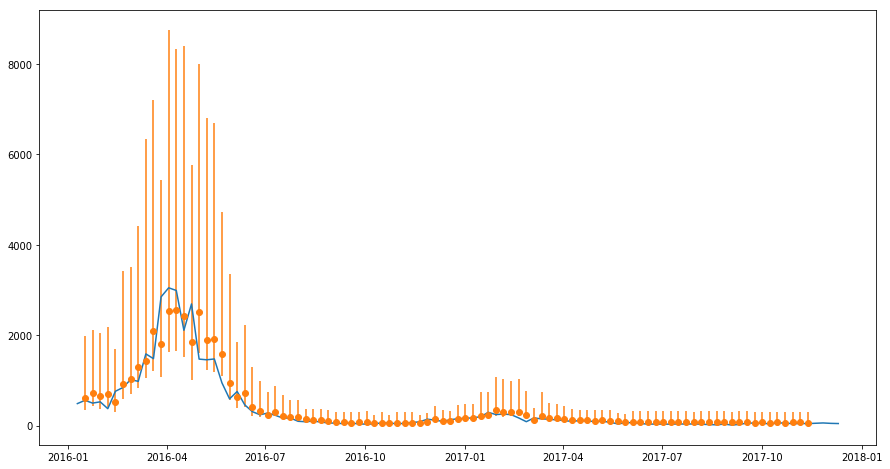

In [416]:
plt.figure(figsize=[15,8])
plt.plot(y_test)
plt.errorbar(x=list(y_test.index)[d:-(horizon-d)], y=preds, yerr=[err_down,err_up], fmt='o',)

In [401]:
to_predict = X_test[:1]

In [404]:
X_test.loc[to_predict.index].p

,casos_3300456,casos_3300456_lag1,casos_3300456_lag10,casos_3300456_lag11,casos_3300456_lag12,casos_3300456_lag2,casos_3300456_lag3,casos_3300456_lag4,casos_3300456_lag5,casos_3300456_lag6,...,umid_min_3306206_lag11,umid_min_3306206_lag12,umid_min_3306206_lag2,umid_min_3306206_lag3,umid_min_3306206_lag4,umid_min_3306206_lag5,umid_min_3306206_lag6,umid_min_3306206_lag7,umid_min_3306206_lag8,umid_min_3306206_lag9
2016-01-10,10,28.0,1.0,5.0,3.0,2.0,11.0,12.0,22.0,5.0,...,52.0,42.714286,63.0,59.0,74.714286,68.285714,56.0,50.714286,51.285714,63.125


In [29]:
def model_by_weeklag(Xtrain, Xtest, ytest, horizon, target):
    '''

    :param Xtrain: train data containing the target column
    :param horizon:
    :param target: target column name
    :return:
    '''
    model_dict = {}
    for d in range(1, horizon + 1):
        tgt = data_lag[target].shift(-d)[:-horizon][:len(Xtrain)]
        tgtt = data_lag[target].shift(-d)[:-horizon][len(Xtrain):]

        model = rolling_forecasts(Xtrain, target=tgt, horizon=horizon)
        plot_prediction(Xtest, ytest, model, 'Out_of_Sample_{}'.format(d), d, horizon)
        plt.show()
        model_dict[d] = model
    return model_dict

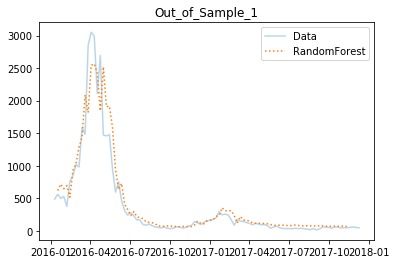

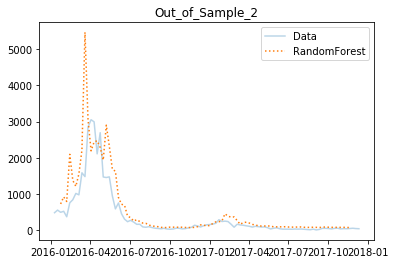

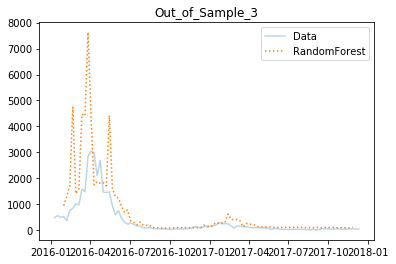

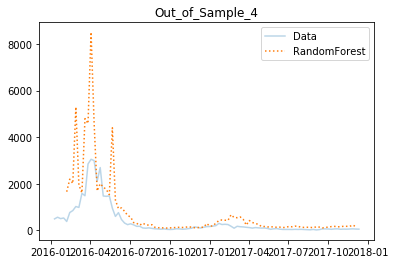

ValueError: Wrong number of items passed 96, placement implies 0

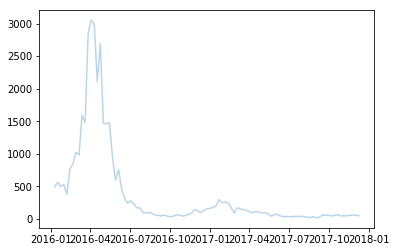

In [30]:
dicte = model_by_weeklag(X_train, X_test, y_test, horizon, target)

In [24]:
def predict_by_weeklag(to_predict, ytest, model_dict):
    '''
    Plot prediction from a sample for each week model
    :param to_predict: sample from features dataframe
    :param ytest: 
    :param model_dict: 
    :return: 
    '''
    ans = {'preds':[], 'index_p':[], 'index_t':[],
           'err_down':[], 'err_up':[]}
    for d in model_dict:
        model = model_dict[d]

        errs = pred_ints(model, to_predict.values, percentile=95)
        ans['err_down'].append(errs[0])
        ans['err_up'].append(errs[1])
        ans['preds'].append(model.predict(to_predict.values))
        ans['index_p'].append(ytest.index[d])
        ans['index_t'].append(ytest.index[d - 1])
    ans['index_t'].append(ans['index_p'][-1])

    plt.plot(ytest.loc[ans['index_t']])
    plt.errorbar(x=ans['index_p'], y=ans['preds'],
                 yerr=[ans['err_down'], ans['err_up']], fmt='o')
    return ans

{'err_down': [[272.95000000000005],
  [234.75000000000003],
  [325.65000000000003],
  [277.875],
  [117.0]],
 'err_up': [[1367.0], [2409.0249999999996], [3431.0], [5121.0], [6296.0]],
 'index_p': [Timestamp('2016-01-17 00:00:00', freq='W-SUN'),
  Timestamp('2016-01-24 00:00:00', freq='W-SUN'),
  Timestamp('2016-01-31 00:00:00', freq='W-SUN'),
  Timestamp('2016-02-07 00:00:00', freq='W-SUN'),
  Timestamp('2016-02-14 00:00:00', freq='W-SUN')],
 'index_t': [Timestamp('2016-01-10 00:00:00', freq='W-SUN'),
  Timestamp('2016-01-17 00:00:00', freq='W-SUN'),
  Timestamp('2016-01-24 00:00:00', freq='W-SUN'),
  Timestamp('2016-01-31 00:00:00', freq='W-SUN'),
  Timestamp('2016-02-07 00:00:00', freq='W-SUN'),
  Timestamp('2016-02-14 00:00:00', freq='W-SUN')],
 'preds': [array([ 619.595]),
  array([ 730.577]),
  array([ 950.242]),
  array([ 1656.006]),
  array([ 2632.484])]}

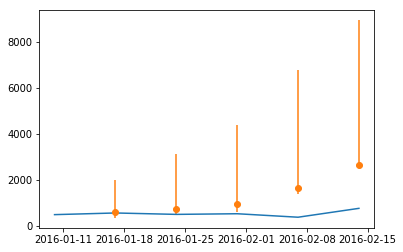

In [25]:
predict_by_weeklag(X_test[:1], y_test, dicte)